# Trabalho Prático 1 - Aprendizado de Máquina
<font size=4>Nome: Alexandre Maros<br></font>
<font size=3>UFMG - 2018/1</font>


Blabla...

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

pd.options.display.max_rows = 10

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# 1. Leitura dos Dados

Para a leitura de dados foi utilizado a biblioteca Pandas por sua facilidade em ler csv's e gerar informações dos dados caso seja necessário.

Essa etapa consiste em simplesmente ler o arquivo com as 5000 entradas e separar em dois dataframes, o dataframe X, referente as features dos dados (os valores de cada pixel de cada entrada) e outro dataframe y específico para as labels das entradas (numero correto do digito de cada entrada).

* O vetor X possui 5000 linhas e 784 colunas
* O vetor y possui 5000 linhas e 1 coluna

In [2]:
# Encontrar Diretorio Atual
diretorio_atual = os.path.realpath('.')

# Ler o arquivo de entrada
dados = pd.read_csv(os.path.join(diretorio_atual, "data_tp1"), sep=",", header=None)

# Armazenar o label correto dos numeros
dados = dados.rename(columns = {0:'label'})
y = dados.label

# Retirar a primeira coluna referente aos labels
X = dados.drop("label", axis=1)

# Modificar o nome das colunas
num_imagens = X.shape[1]
X.columns = [ int(x) for x in range(0, num_imagens)] 

X

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. Visualização dos dados

O propósito desta etapa está em analisar os dados para melhor entender como os mesmos se comportam.

Inicialmente é feito a visualização das três primeiras entradas, para verificar como é a estrutura dos dígitos e em sequência é verificado a distribuição dos dígitos dentro do dataset.

### Visualização dos três primeiro dígitos do dataset

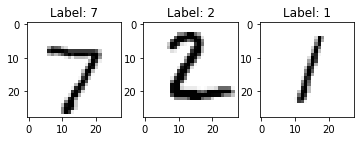

In [3]:
digitos = [ X.loc[0,:], X.loc[1,:], X.loc[2,:] ]
labels = [ y[0], y[1], y[2] ]

# 784 colunas correspondem a uma imagem de 28x28
plot1 = np.reshape(digitos[0].values, (28, 28))
plot2 = np.reshape(digitos[1].values, (28, 28))
plot3 = np.reshape(digitos[2].values, (28, 28))

fig=plt.figure(figsize=(8, 8))

# Plot the digits
fig.add_subplot(4, 4, 1)
plt.imshow(plot1, cmap='gray_r')
plt.title('Label: {}'.format(labels[0]))

fig.add_subplot(4, 4, 2)
plt.imshow(plot2, cmap='gray_r')
plt.title('Label: {}'.format(labels[1]))

fig.add_subplot(4, 4, 3)
plt.imshow(plot3, cmap='gray_r')
plt.title('Label: {}'.format(labels[2]))

plt.show()


### Verificando a distribuição dos dígitos

É interessante verificar a disposição (frequência) dos dígitos no dataset. Se tiver muitos digitos 1 e poucos dígitos 9 isso pode levar a uma má previsão.

In [4]:
y.value_counts(normalize=True).sort_index()

0    0.0920
1    0.1142
2    0.1060
3    0.1000
4    0.1000
5    0.0912
6    0.0924
7    0.1024
8    0.0978
9    0.1040
Name: label, dtype: float64

Os dígitos parecem estar bem distribuídos, sendo que os dígitos 0 e 5 são os dois digitos que menos aparecem (9.2% dos dígitos são o dígito 0 e 0.912% dos digitos são o dígito 5). O dígito 1 é o que mais aparece, com sua frequência em 11%.

# 3. Construção dos Modelos

Esta seção descreve a construção dos modelos e uma análise sobre seus resultados. Para gerar os modelos foi utilizado principalemnte a classe MLPClassifier da biblioteca scikit-learn do Python.

## 3.1 Feature Scaling

As redes neurais de múltiplas camandas são muito sensíveis a variância da unidade dos dados. Para diminuir esses efeitos a biblioteca scikit-learn sugere que os dados sejam "_ajustados_" de acordo com sua média e desvio padrão, de forma a diminuir os efeitos da variância e deixar os dados parecidos com uma distribuição normal [1]. Nesta etapa é exatamente isso que está sendo feito. Os numeros dos píxels estão sendo convertidos de [0,255] para [-1,+1]

[1]: Mais informações em: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

In [5]:
scaler = StandardScaler()
scaler.fit(X)
StandardScaler(copy=True, with_mean=True, with_std=True)
X = scaler.transform(X)

## 3.2 Definição das funções

Aqui está sendo definido as funções que facilitarão a análise.

A primeira função (**plot_learning_curve**) toma como principais parâmetros um modelo ainda não calculado, e as séries de treinamento.

Essa função calcula o impacto que a quantidade de dados utilizados no treinamento tem no modelo e valida essa informação utilizando **10-fold cross validation**. A quantidade de treinos utilizada vai de 10% da quantidade inicial até 100%, variando de 10% a cada etapa.

A função de "pontuação" do gráfico é a "negative log loss", logo, quanto maior o valor menos erro.

In [6]:
def plot_learning_curve(estimator, X, y, title="Default Title", ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    fig = plt.figure(figsize=(13, 6), dpi= 80)
    plt.style.use('ggplot')

    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Exemplos de Treinamento")
    plt.ylabel("Pontuação")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
        cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_log_loss')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Pontuação de Treinamento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Pontuação de Cross-validation")

    plt.legend(loc="best")
    return plt


A função **plot_loss_curve** é uma simples função para desenhar a curva de perda de cada iteração do modelo.

In [7]:
def plot_loss_curve(loss_curve_, title='Default Title'):
    fig = plt.figure(figsize=(13, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.style.use('ggplot')
    
    plt.title(title)
    
    plt.plot(loss_curve_, '-', color='blue', linewidth=3.0)
    
    plt.ylabel('Função de perda')
    plt.xlabel('Número de Iterações')
    
    return plt

## 3.3 Teste dos modelos

Aqui é testado os modelos com os diferentes hiperparâmetros. São testadas as seguintes variações:

1. Variação do Learning Rate
2. Variação do Número de Camadas na camada oculta
3. Variação do algoritmo de cálculo de gradiente (Gradient Descent, Stochastic Gradient Descent, Mini-Batch SGD)

Os outros hiperparâmetros são fixos, sendo eles:

1. Função de ativação: sigmoide
2. Tolerância (quando o modelo para de treinar pois atingiu convergência): 1e-4
3. Máximas iterações: 300
4. Momentum: 0.5

### 3.3.1 Variação do learning rate

Para testar a variação do learning rate **será fixado o número de camadas na camada oculta em 50 e será usado o mini-batch SGD com 200 entradas** (esse é o _default_ do scikit-learn).

Inicialmente verifica-se como o modelo se comporta quando o learning rate está configurado para **0.5, 1 e 10**, seguido de um teste com um learning rate mais baixo (**0.01**), pois é verificado que os _learning rates_ iniciais são grandes e causam _overfitting_.

#### Learning Rate = 0.5

<module 'matplotlib.pyplot' from '/home/apm/git/venv-mnist/lib/python3.5/site-packages/matplotlib/pyplot.py'>

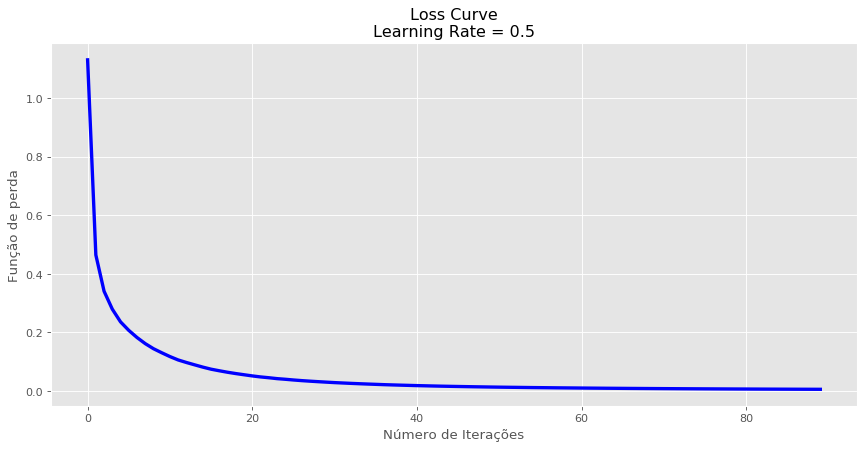

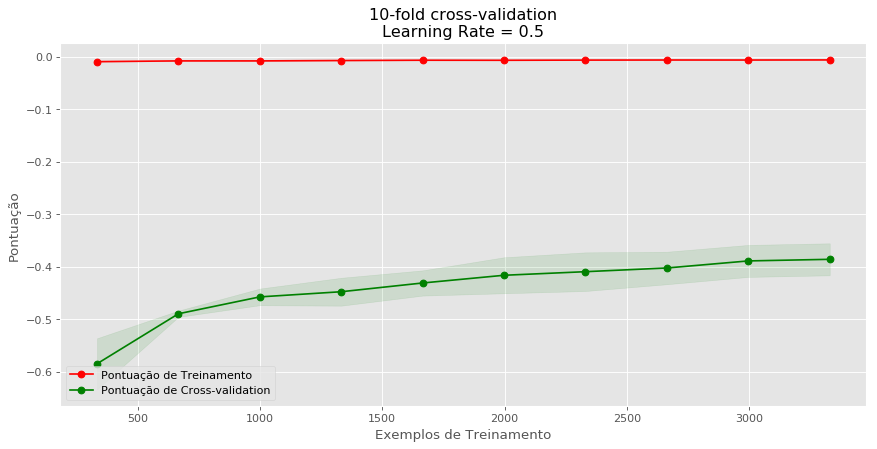

In [8]:
learning_rate=0.5

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nLearning Rate = {}".format(learning_rate))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nLearning Rate = {}".format(learning_rate), n_jobs=6)

comentarios...

#### Learning Rate = 1

<module 'matplotlib.pyplot' from '/home/apm/git/venv-mnist/lib/python3.5/site-packages/matplotlib/pyplot.py'>

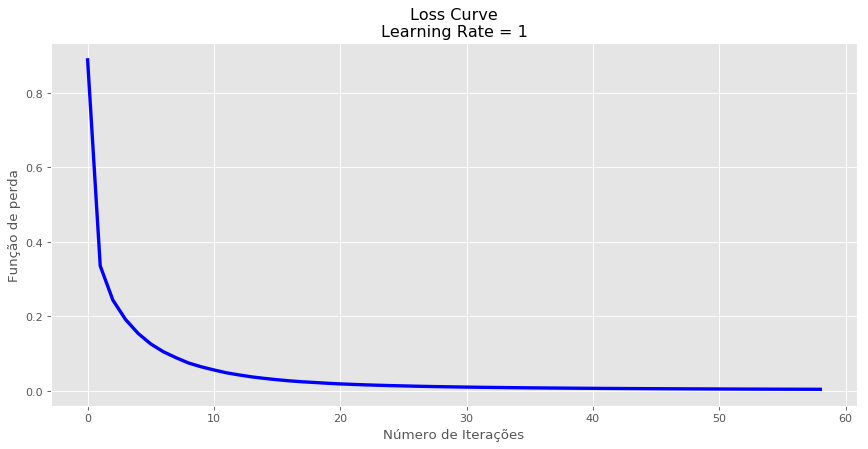

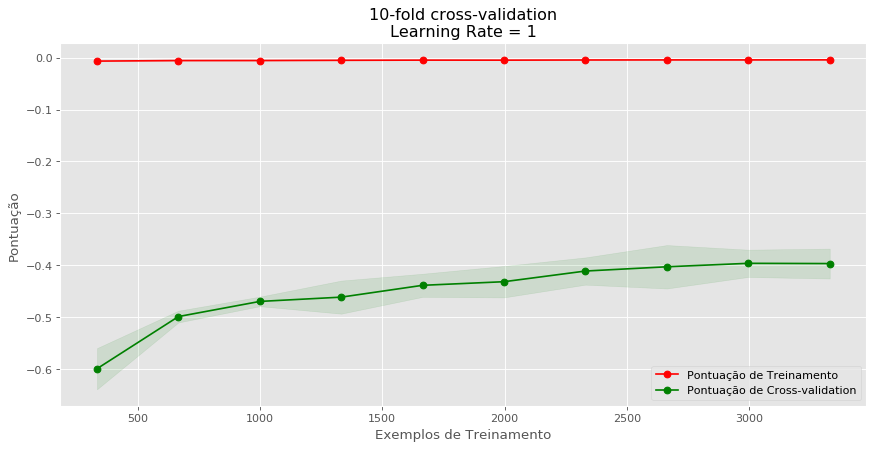

In [9]:
learning_rate=1

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nLearning Rate = {}".format(learning_rate))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nLearning Rate = {}".format(learning_rate), n_jobs=6)

comentarios...

#### Learning Rate = 10

<module 'matplotlib.pyplot' from '/home/apm/git/venv-mnist/lib/python3.5/site-packages/matplotlib/pyplot.py'>

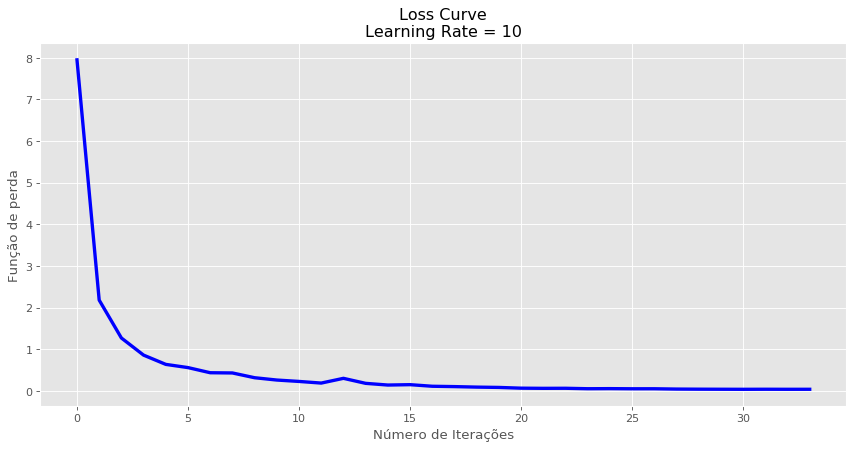

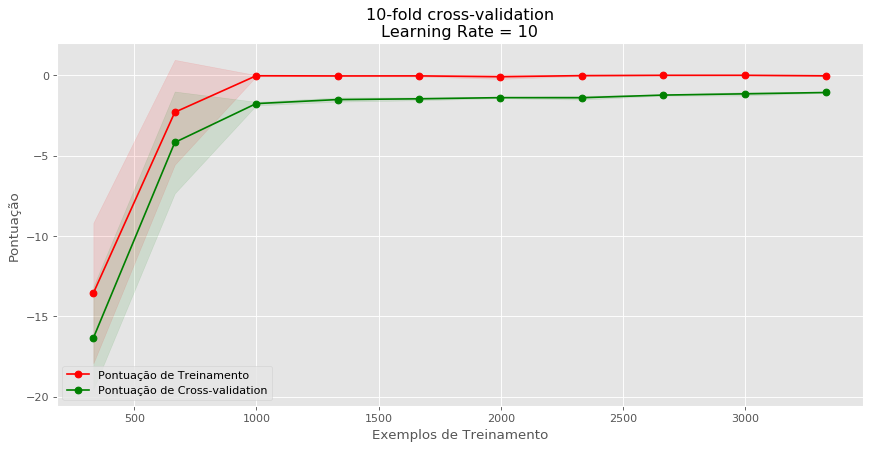

In [10]:
learning_rate=10

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nLearning Rate = {}".format(learning_rate))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nLearning Rate = {}".format(learning_rate), n_jobs=6)

comentarios...

#### Learning Rate = 0.01

<module 'matplotlib.pyplot' from '/home/apm/git/venv-mnist/lib/python3.5/site-packages/matplotlib/pyplot.py'>

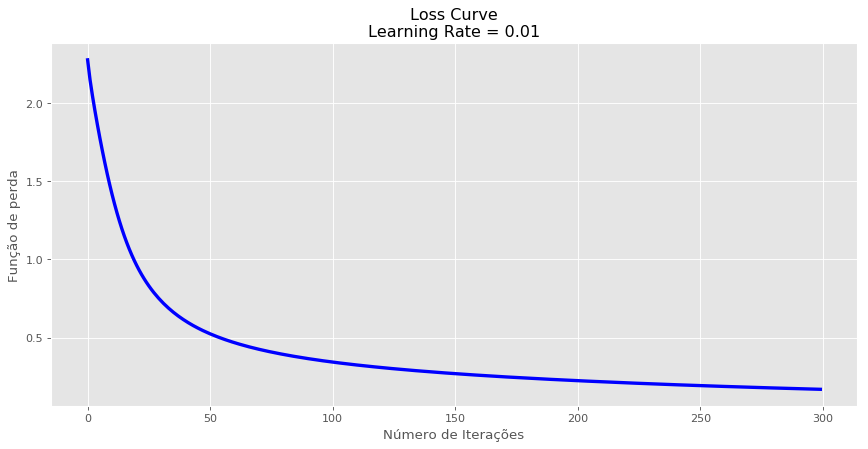

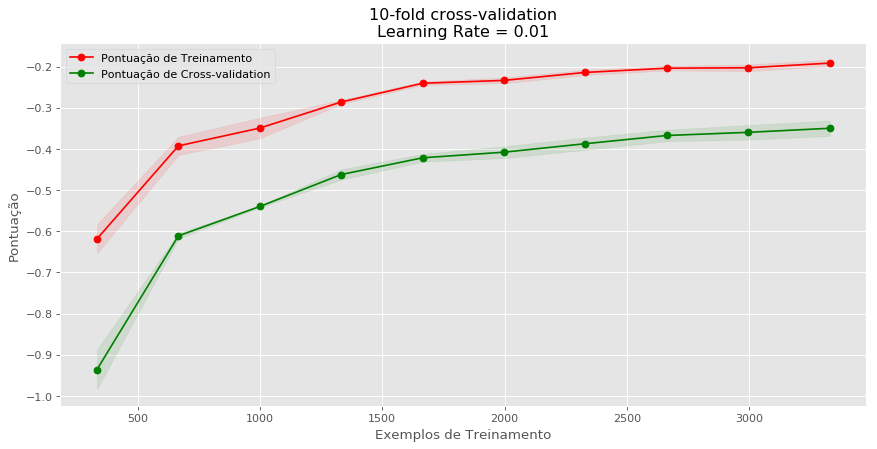

In [11]:
learning_rate=0.01

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nLearning Rate = {}".format(learning_rate))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=learning_rate, max_iter=300, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nLearning Rate = {}".format(learning_rate), n_jobs=6)

comentarios...

### 3.3.2 Variação do número de camdas ocultas

<module 'matplotlib.pyplot' from '/home/apm/git/venv-mnist/lib/python3.5/site-packages/matplotlib/pyplot.py'>

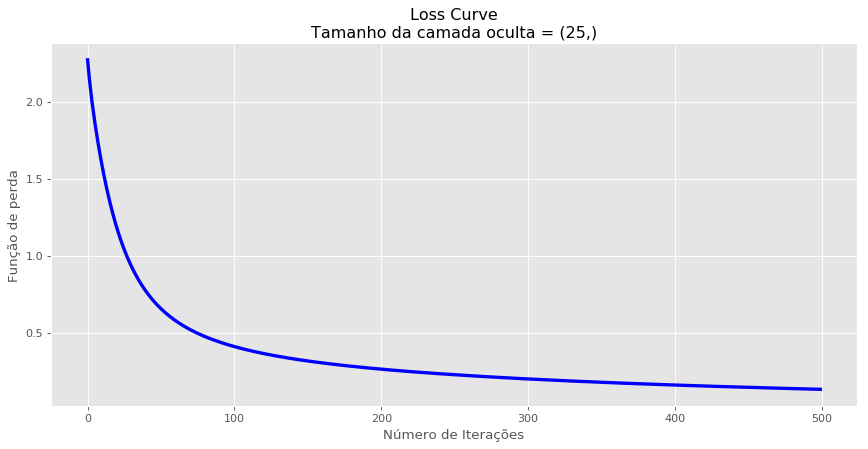

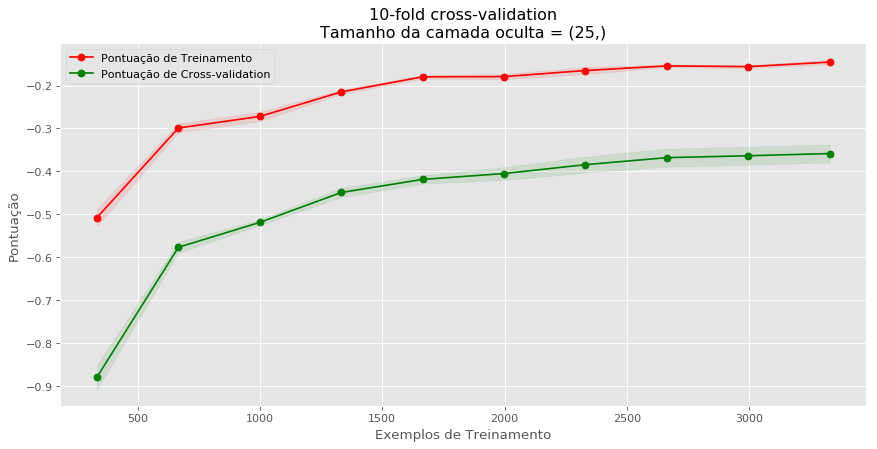

In [12]:
hidden_layer_sizes=(25,)

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nTamanho da camada oculta = {}".format(hidden_layer_sizes))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nTamanho da camada oculta = {}".format(hidden_layer_sizes), n_jobs=6)

<module 'matplotlib.pyplot' from '/home/apm/git/venv-mnist/lib/python3.5/site-packages/matplotlib/pyplot.py'>

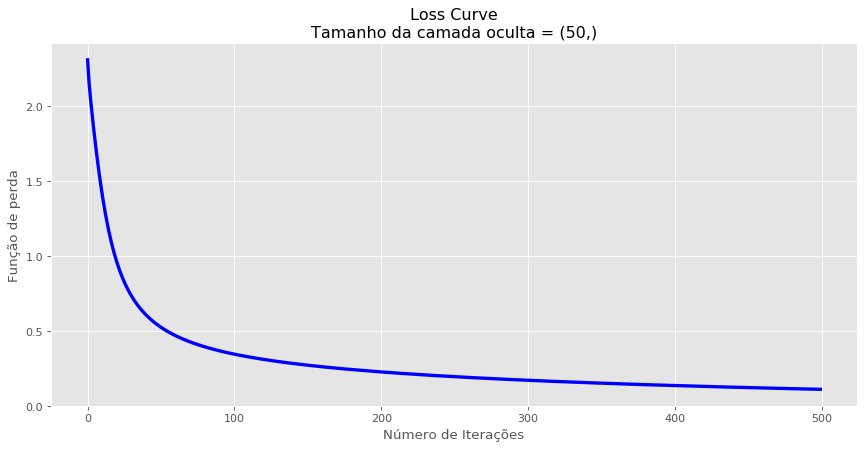

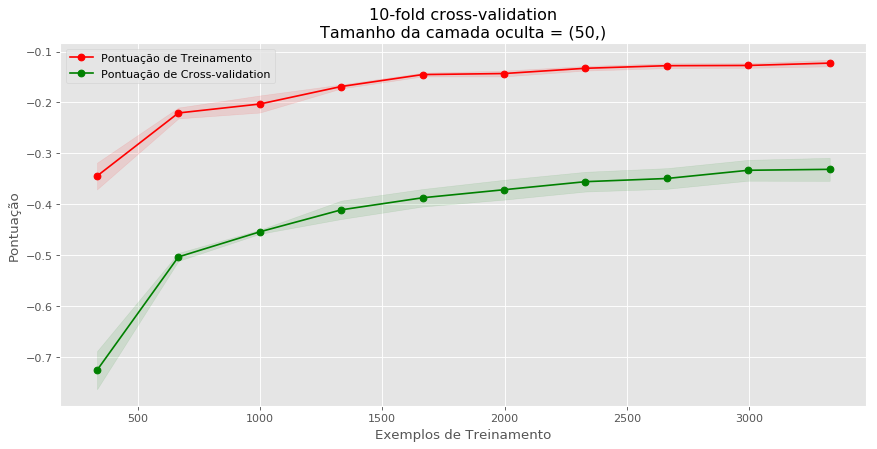

In [13]:
hidden_layer_sizes=(50,)

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nTamanho da camada oculta = {}".format(hidden_layer_sizes))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nTamanho da camada oculta = {}".format(hidden_layer_sizes), n_jobs=6)

<module 'matplotlib.pyplot' from '/home/apm/git/venv-mnist/lib/python3.5/site-packages/matplotlib/pyplot.py'>

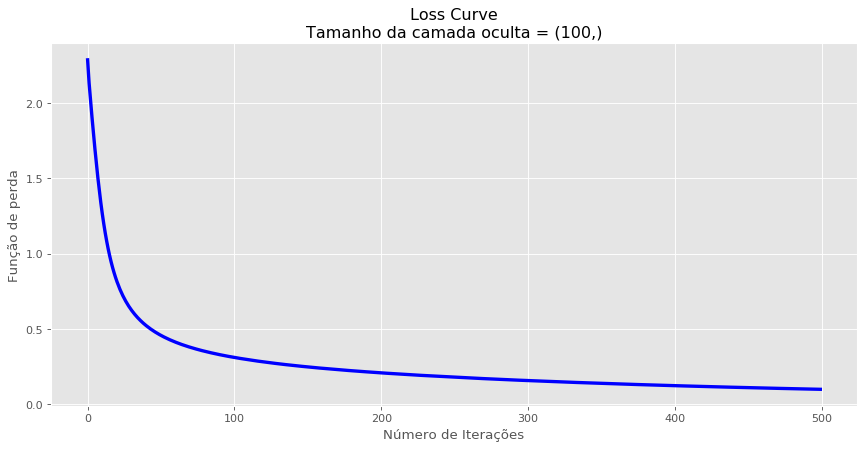

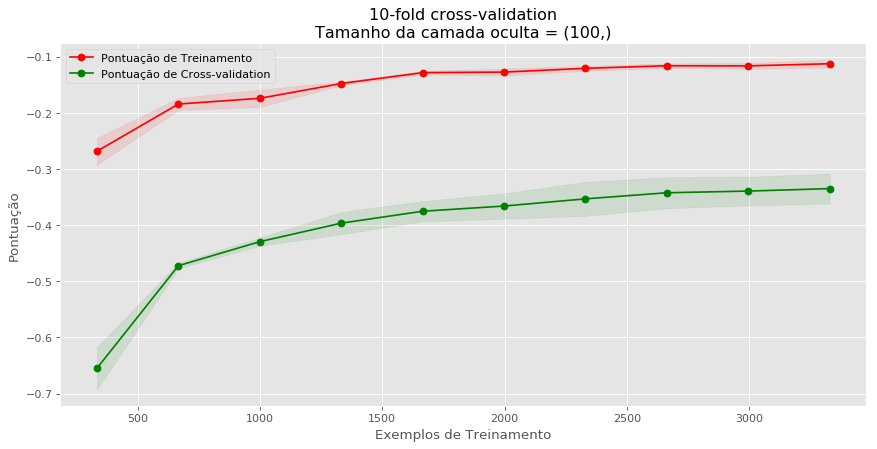

In [14]:
hidden_layer_sizes=(100,)

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nTamanho da camada oculta = {}".format(hidden_layer_sizes))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=200, early_stopping=False,
                    hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nTamanho da camada oculta = {}".format(hidden_layer_sizes), n_jobs=6)

### 3.3.3 Variação do algoritmo de gradiente

In [ ]:
batch_size=5000

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=batch_size, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nGradient Descent")


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=batch_size, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\Gradient Descent", n_jobs=6)

In [ ]:
batch_size=1

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=batch_size, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nStochastic Gradient Descent")


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=batch_size, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\Stochastic Gradient Descent", n_jobs=6)

In [ ]:
batch_size=10

clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=batch_size, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
clf_trained = clf.fit(X, y)
plot_loss_curve(clf_trained.loss_curve_, title="Loss Curve\nMini-Batch Stochastic Gradient Descent ({})".format(batch_size))


clf = MLPClassifier(solver='sgd', activation='logistic', batch_size=batch_size, early_stopping=False,
                    hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500, momentum=0.5,
                    shuffle=True, verbose=False, tol=1e-4)
plot_learning_curve(clf, X, y, title="10-fold cross-validation\nMini-Batch Stochastic Gradient Descent ({})".format(batch_size), n_jobs=6)